### Importing Essential Libraries for EDA

In [1]:
import numpy as np
import pandas as pd
import os
from icecream import ic

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
sns.set()

### Importing the Custom Dataset

In [3]:
data_dir: str = './Dataset/Custom DataSet/'
image_ext: list() = ['jpeg','jpg','png','bmp']
disease_type: list() = os.listdir(data_dir)

print(f"Total Dir's: {len(os.listdir(data_dir))} \n Total Diseases: {len(disease_type)}")

Total Dir's: 29 
 Total Diseases: 29


### Cleaning the Dataset

In [18]:
import imghdr
for image_class in disease_type:
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path: str = os.path.join(os.path.join(data_dir,image_class,image))

        try:
            img = cv2.imread(image_path)
            tip: str = imghdr.what(image_path)

            if tip not in image_ext:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")

Issue with image ./Dataset/Custom DataSet/apple_scab/.AU.O1Dcb.nosync
Image not in ext list ./Dataset/Custom DataSet/tomato_powdery_mildew/.DS_Store
Image not in ext list ./Dataset/Custom DataSet/tomato_powdery_mildew/602-114-0.jpg
Image not in ext list ./Dataset/Custom DataSet/tomato_powdery_mildew/powdery-mildew-tomatoes-growingmagazine.jpg
Image not in ext list ./Dataset/Custom DataSet/tomato_powdery_mildew/powdery-mildew-on-tomatoes.png
Issue with image ./Dataset/Custom DataSet/tomato_powdery_mildew/.AU.MuPUa.nosync
Image not in ext list ./Dataset/Custom DataSet/sunflower_aster_yellow/962f1b72-c96e-4f12-be62-50717ba2c61d.zip
Image not in ext list ./Dataset/Custom DataSet/rose_healthy/.DS_Store
Image not in ext list ./Dataset/Custom DataSet/lettuce_downy_mildew/.DS_Store
Image not in ext list ./Dataset/Custom DataSet/lettuce_downy_mildew/Powdery-mildew-and-Downy-Mildew-collage.jpg
Image not in ext list ./Dataset/Custom DataSet/lettuce_downy_mildew/ppa_2399_f1.gif
Image not in ext li

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image not in ext list ./Dataset/Custom DataSet/lettuce_healthy/rand-seeds-from-Shashi-n-Gautam-Kitchen-Gardeners-Web-Shop-India-Online.jpg.webp
Image not in ext list ./Dataset/Custom DataSet/lettuce_healthy/.DS_Store
Image not in ext list ./Dataset/Custom DataSet/lettuce_healthy/89ff6c81b44a48a4b1982b708379dde5.webp
Image not in ext list ./Dataset/Custom DataSet/lettuce_healthy/lettuce-leafy-250-g-approx-160-g-300-g-product-images-o590003486-p590034372-0-202203171010.jpg
Image not in ext list ./Dataset/Custom DataSet/lettuce_healthy/best-lettuce-for-burgers.jpeg


### Loading Dataset

In [5]:
import tensorflow as tf

In [6]:
gpus = tf.config.experimental.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 22171 files belonging to 28 classes.


2024-01-12 22:17:18.960189: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-12 22:17:18.960216: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-12 22:17:18.960226: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-12 22:17:18.960261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 22:17:18.960277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
data_iterator

In [12]:
batch = data_iterator.next()

In [13]:
len(batch)

2

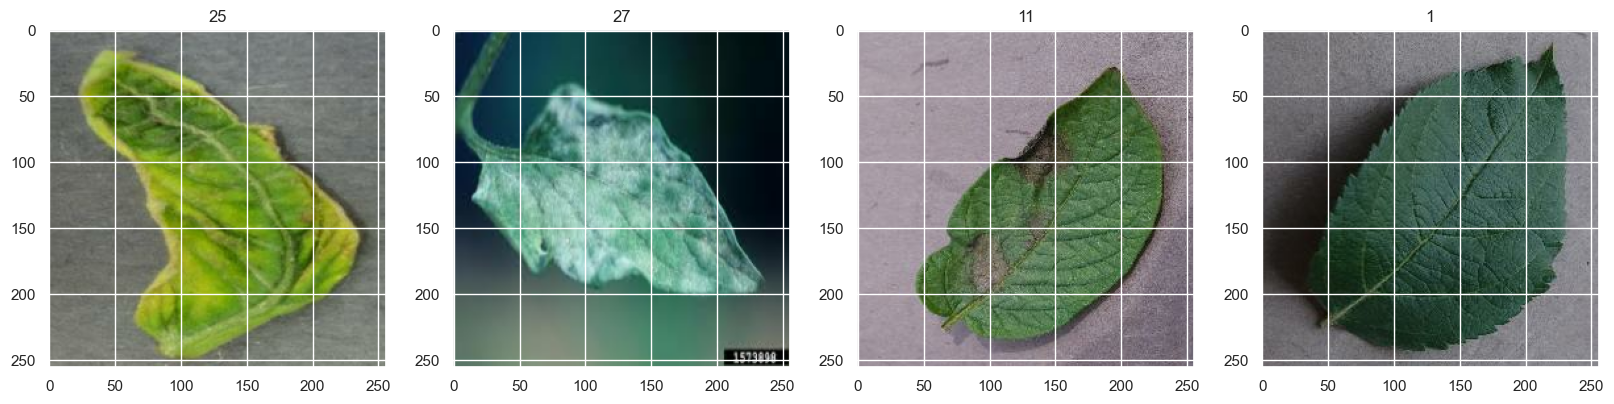

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [16]:
len(data)

693

### Pre-Processing of data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

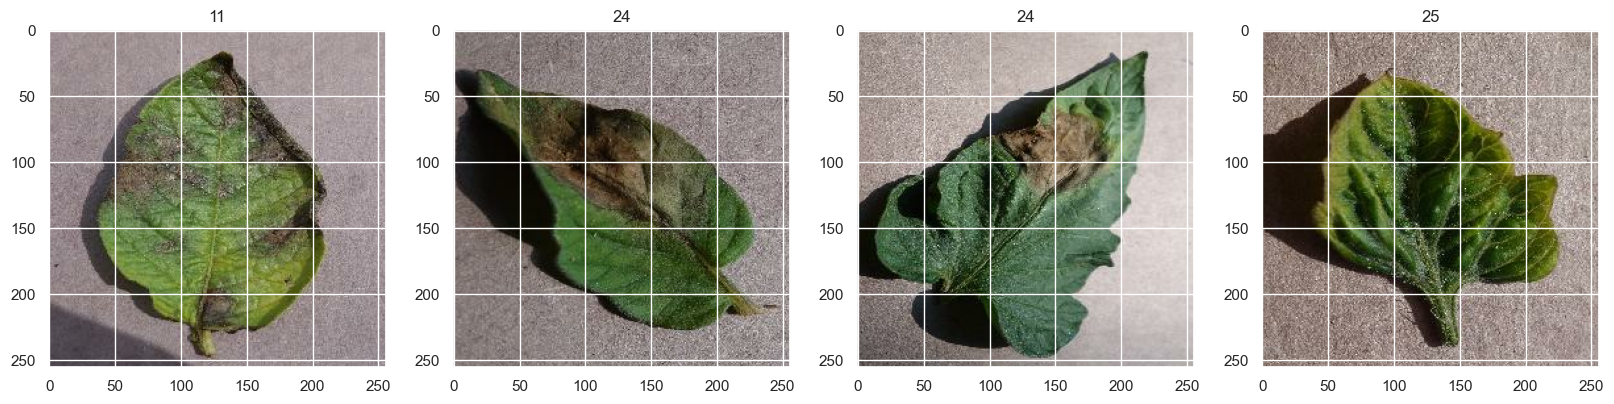

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

### Split Data into Train,Test,Validate

In [21]:
len(data)

693

In [22]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [23]:
print(f"Train Size: {train_size}\nTest Size: {test_size}\nVal Size: {val_size}")

Train Size: 485
Test Size: 70
Val Size: 138


In [24]:
assert(train_size+test_size+val_size == len(data))

In [25]:
train = data.take(train_size)
test = data.skip(train_size+val_size).take(test_size)
val = data.skip(train_size).take(val_size)

### CNN Model DenseNet121

In [26]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import DenseNet121

In [27]:
type(train)

tensorflow.python.data.ops.take_op._TakeDataset

In [32]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Creating Model Outline

In [55]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layers in densenet.layers:
    layers.trainable = False


x = GlobalAveragePooling2D()(densenet.output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)

predictions = Dense(28, activation='softmax')(x)

model = Model(inputs=densenet.input,outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 262, 262, 3)          0         ['input_10[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_18[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

- Creating log files

In [53]:
logdir = './logs/'
tensorboard_callbacks = TensorBoard(log_dir=logdir)

#### Training the DenseNet Model

In [56]:
hist = model.fit(train,
                epochs=15,
                validation_data=val,
                callbacks = [tensorboard_callbacks])

Epoch 1/15


2024-01-12 22:35:29.810718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


477/485 [============================>.] - ETA: 4s - loss: 0.3332 - accuracy: 0.9118

2024-01-12 22:40:12.904115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.9124

2024-01-12 22:40:50.445869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 407s 791ms/step - loss: 0.3296 - accuracy: 0.9124 - val_loss: 0.2229 - val_accuracy: 0.9370
Epoch 2/15
477/485 [============================>.] - ETA: 4s - loss: 0.1335 - accuracy: 0.9589

2024-01-12 22:46:50.642596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9586

2024-01-12 22:47:25.635144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 380s 781ms/step - loss: 0.1340 - accuracy: 0.9586 - val_loss: 0.1886 - val_accuracy: 0.9502
Epoch 3/15
477/485 [============================>.] - ETA: 4s - loss: 0.1097 - accuracy: 0.9652

2024-01-12 22:52:38.213427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9653

2024-01-12 22:53:12.289863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 340s 701ms/step - loss: 0.1093 - accuracy: 0.9653 - val_loss: 0.1407 - val_accuracy: 0.9588
Epoch 4/15
477/485 [============================>.] - ETA: 3s - loss: 0.0893 - accuracy: 0.9711

2024-01-12 22:57:57.564526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9712

2024-01-12 22:58:30.969387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 319s 657ms/step - loss: 0.0888 - accuracy: 0.9712 - val_loss: 0.1691 - val_accuracy: 0.9558
Epoch 5/15
477/485 [============================>.] - ETA: 4s - loss: 0.0786 - accuracy: 0.9725

2024-01-12 23:03:48.898714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9726

2024-01-12 23:04:23.464993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 358s 738ms/step - loss: 0.0785 - accuracy: 0.9726 - val_loss: 0.1896 - val_accuracy: 0.9547
Epoch 6/15
477/485 [============================>.] - ETA: 4s - loss: 0.0717 - accuracy: 0.9756

2024-01-12 23:09:36.748765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9756

2024-01-12 23:10:11.851942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 348s 716ms/step - loss: 0.0717 - accuracy: 0.9756 - val_loss: 0.1574 - val_accuracy: 0.9626
Epoch 7/15
477/485 [============================>.] - ETA: 4s - loss: 0.0657 - accuracy: 0.9777

2024-01-12 23:15:23.143995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9778

2024-01-12 23:15:58.359012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 348s 717ms/step - loss: 0.0652 - accuracy: 0.9778 - val_loss: 0.1473 - val_accuracy: 0.9642
Epoch 8/15
477/485 [============================>.] - ETA: 3s - loss: 0.0626 - accuracy: 0.9783

2024-01-12 23:21:03.049918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9783

2024-01-12 23:21:37.291199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 333s 685ms/step - loss: 0.0624 - accuracy: 0.9783 - val_loss: 0.1564 - val_accuracy: 0.9615
Epoch 9/15
477/485 [============================>.] - ETA: 4s - loss: 0.0584 - accuracy: 0.9800

2024-01-12 23:26:48.512212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9800

2024-01-12 23:27:23.525451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 351s 723ms/step - loss: 0.0585 - accuracy: 0.9800 - val_loss: 0.1658 - val_accuracy: 0.9620
Epoch 10/15
477/485 [============================>.] - ETA: 4s - loss: 0.0590 - accuracy: 0.9794

2024-01-12 23:32:40.152999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9792

2024-01-12 23:33:15.442918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 353s 727ms/step - loss: 0.0596 - accuracy: 0.9792 - val_loss: 0.1588 - val_accuracy: 0.9624
Epoch 11/15
477/485 [============================>.] - ETA: 4s - loss: 0.0517 - accuracy: 0.9807

2024-01-12 23:38:38.928164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9807

2024-01-12 23:39:14.188407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 358s 737ms/step - loss: 0.0515 - accuracy: 0.9807 - val_loss: 0.2048 - val_accuracy: 0.9595
Epoch 12/15
477/485 [============================>.] - ETA: 4s - loss: 0.0635 - accuracy: 0.9801

2024-01-12 23:44:29.478852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9798

2024-01-12 23:45:04.493115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 351s 723ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 0.1805 - val_accuracy: 0.9604
Epoch 13/15
477/485 [============================>.] - ETA: 4s - loss: 0.0444 - accuracy: 0.9845

2024-01-12 23:50:24.428439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9847

2024-01-12 23:50:59.445944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 355s 731ms/step - loss: 0.0444 - accuracy: 0.9847 - val_loss: 0.1677 - val_accuracy: 0.9633
Epoch 14/15
477/485 [============================>.] - ETA: 4s - loss: 0.0502 - accuracy: 0.9836

2024-01-12 23:56:12.200791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9832

2024-01-12 23:56:47.617840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 348s 717ms/step - loss: 0.0510 - accuracy: 0.9832 - val_loss: 0.1629 - val_accuracy: 0.9626
Epoch 15/15
477/485 [============================>.] - ETA: 4s - loss: 0.0526 - accuracy: 0.9827

2024-01-13 00:02:02.713510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9829

2024-01-13 00:02:38.130073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


485/485 [==============================] - 350s 721ms/step - loss: 0.0519 - accuracy: 0.9829 - val_loss: 0.1893 - val_accuracy: 0.9633


- Saved the Created Model

In [57]:
model.save("Plant_Disease_DenseNet121.h5")

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluating the model

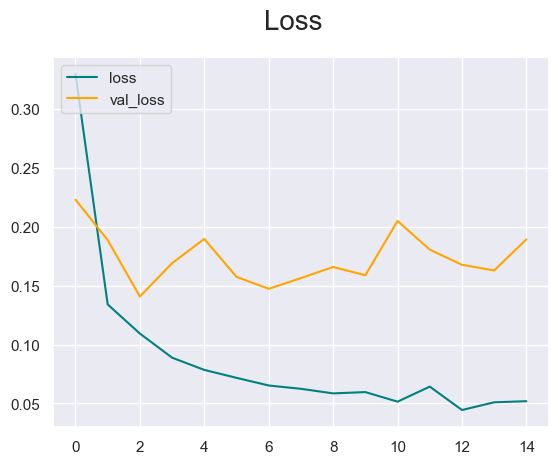

In [58]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

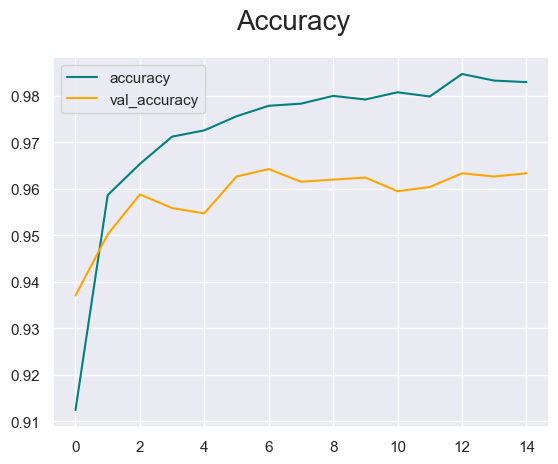

In [59]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [61]:
final_loss, final_accuracy = model.evaluate(val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

2024-01-13 00:24:32.673841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


138/138 [==============================] - 101s 517ms/step - loss: 0.1858 - accuracy: 0.9640
Final Loss: 0.1857934296131134, Final Accuracy: 0.963994562625885


In [139]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Testing the Model on Test dataset

In [73]:
test_loss, test_accuracy = model.evaluate(test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

2024-01-13 01:00:01.155129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


29/70 [===========>..................] - ETA: 44s - loss: 0.1619 - accuracy: 0.9634

2024-01-13 01:00:46.392653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/70 [==============================] - 157s 1s/step - loss: 0.1789 - accuracy: 0.9647
Test loss: 0.17889147996902466
Test accuracy: 0.9646532535552979


## Now Using ResNet50V2

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

In [6]:
data_dir = "./Dataset/Custom DataSet/"

- Importing data set using ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

In [13]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 17746 images belonging to 28 classes.
Found 17746 images belonging to 28 classes.


#### Creating the ResNet50V2 Model

In [16]:
densenet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in densenet.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(densenet.output)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(28, activation='softmax')(x)

model = Model(inputs = densenet.input, outputs = predictions)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

2024-01-13 18:04:58.651719: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-13 18:04:58.651781: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-13 18:04:58.651792: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-13 18:04:58.652053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 18:04:58.652359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [17]:
from tensorflow.keras.callbacks import TensorBoard

In [18]:
logdir = './resnet_logs/'
tensorboard_callbacks = TensorBoard(log_dir=logdir)

In [20]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [22]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.samples // 32,
    callbacks = [tensorboard_callbacks]
)

Epoch 1/10
166/554 [=======>......................] - ETA: 1:43 - loss: 0.4868 - accuracy: 0.8951

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


554/554 [==============================] - 363s 655ms/step - loss: 0.5693 - accuracy: 0.8946 - val_loss: 0.5671 - val_accuracy: 0.8966
Epoch 2/10


2024-01-13 18:30:41.489936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12839524252444742338


554/554 [==============================] - 190s 342ms/step - loss: 0.5635 - accuracy: 0.9069
Epoch 3/10
554/554 [==============================] - 192s 347ms/step - loss: 0.6624 - accuracy: 0.9057
Epoch 4/10
554/554 [==============================] - 194s 350ms/step - loss: 0.6010 - accuracy: 0.9217
Epoch 5/10
554/554 [==============================] - 194s 350ms/step - loss: 0.6071 - accuracy: 0.9241
Epoch 6/10
554/554 [==============================] - 195s 352ms/step - loss: 0.5899 - accuracy: 0.9290
Epoch 7/10
554/554 [==============================] - 197s 355ms/step - loss: 0.6292 - accuracy: 0.9303
Epoch 8/10
554/554 [==============================] - 196s 353ms/step - loss: 0.6635 - accuracy: 0.9343
Epoch 9/10
554/554 [==============================] - 197s 355ms/step - loss: 0.6049 - accuracy: 0.9402
Epoch 10/10
554/554 [==============================] - 198s 357ms/step - loss: 0.6081 - accuracy: 0.9411


In [26]:
model.save("Plant_Disease_ResNet50V2.h5")

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
final_loss, final_accuracy = model.evaluate(val_generator)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

121/555 [=====>........................] - ETA: 1:54 - loss: 0.8175 - accuracy: 0.9274

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


555/555 [==============================] - 153s 275ms/step - loss: 0.7814 - accuracy: 0.9315
Final Loss: 0.7813611030578613, Final Accuracy: 0.9314774870872498


#### Adding Custom layers for better performance

In [29]:
from tensorflow.keras.layers import Dropout, BatchNormalization

In [30]:
resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224, 3))

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)

prediction = Dense(28, activation = 'softmax')(x)

model = Model(inputs = resnet.input, outputs = prediction)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [31]:
hist = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.samples // 32,
    callbacks = [tensorboard_callbacks]
)

Epoch 1/10
350/554 [=================>............] - ETA: 1:00 - loss: 0.6714 - accuracy: 0.8017

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


554/554 [==============================] - 384s 674ms/step - loss: 0.5786 - accuracy: 0.8265 - val_loss: 0.2640 - val_accuracy: 0.9116
Epoch 2/10
554/554 [==============================] - 389s 703ms/step - loss: 0.3288 - accuracy: 0.8935 - val_loss: 0.2169 - val_accuracy: 0.9274
Epoch 3/10
554/554 [==============================] - 390s 704ms/step - loss: 0.2825 - accuracy: 0.9040 - val_loss: 0.1851 - val_accuracy: 0.9323
Epoch 4/10
554/554 [==============================] - 393s 709ms/step - loss: 0.2526 - accuracy: 0.9137 - val_loss: 0.1490 - val_accuracy: 0.9505
Epoch 5/10
554/554 [==============================] - 396s 715ms/step - loss: 0.2252 - accuracy: 0.9235 - val_loss: 0.1370 - val_accuracy: 0.9535
Epoch 6/10
554/554 [==============================] - 398s 718ms/step - loss: 0.2190 - accuracy: 0.9262 - val_loss: 0.1536 - val_accuracy: 0.9439
Epoch 7/10
554/554 [==============================] - 402s 725ms/step - loss: 0.2050 - accuracy: 0.9305 - val_loss: 0.1269 - val_accura

In [32]:
final_loss, final_accuracy = model.evaluate(val_generator)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

555/555 [==============================] - 179s 323ms/step - loss: 0.1107 - accuracy: 0.9613
Final Loss: 0.11065328866243362, Final Accuracy: 0.9612870216369629


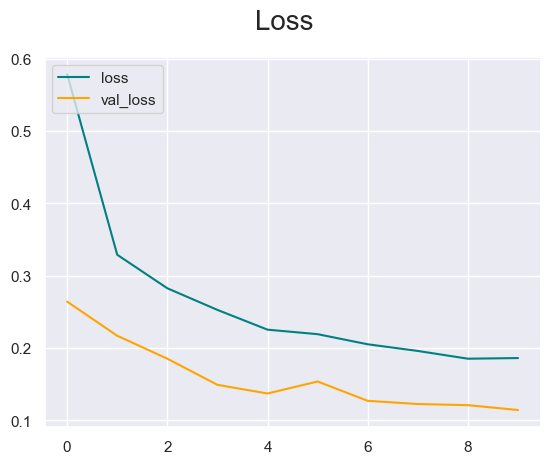

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

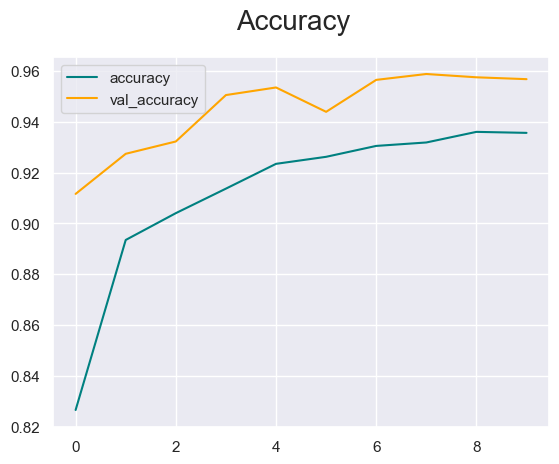

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [35]:
model.save("Plant_Disease_ResNet50V2_New.h5")

/Users/aryankaushik/Major Project NTCC/Implimentation/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Testing the model

In [36]:
from tensorflow.keras.preprocessing import image

In [39]:
def load_image(path):
    img = image.load_img(path, target_size = (224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255


    return img_array

- 1

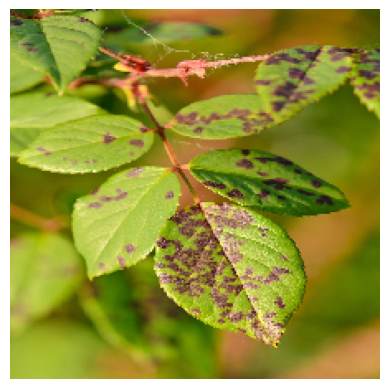

In [49]:
img_path = './test_img/Downy-Mildew-on-Roses.jpg'
img_array = load_image(img_path)

In [50]:
pred = model.predict(img_array)

1/1 [==============================] - 0s 197ms/step


In [51]:
top_k_value, top_k_indicators = tf.nn.top_k(pred[0], k=3)

print("Top 3 Predictions are:")
for value, index in zip(top_k_value.numpy(), top_k_indicators.numpy()):
    print(f"Class {index} with probability {value}")

Top 3 Predictions are:
Class 15 with probability 0.4497550427913666
Class 21 with probability 0.2730806767940521
Class 4 with probability 0.07947547733783722


In [59]:
class_indices = train_generator.class_indices
class_name = list(class_indices.keys())

In [63]:
class_name[15]

'rose_powdery_mildew'

- 2

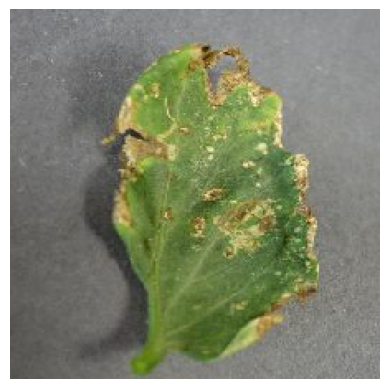

In [66]:
img_path = './test_img/tomato Bacterial.JPG'
img_array = load_image(img_path)

In [67]:
pred = model.predict(img_array)

1/1 [==============================] - 0s 181ms/step


In [68]:
id_pred = np.argmax(pred, axis=1)

print(class_name[id_pred[0]])

tomato_Bacterial_spot
